##FinalDatasetPreparation

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import random
from nltk.corpus import wordnet

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Coventry_Final_Year_Projects/CHARAN/spam_sms.csv')

# Get stop words once
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into string
    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['v2'].apply(preprocess_text)

# Augmentation functions
def synonym_replacement(words, n):
    if not words:
        return words
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def random_insertion(words, n):
    if not words:
        return words
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

def add_word(new_words):
    if not new_words:
        return
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        if len(new_words) == 0:
            return
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

def random_swap(words, n):
    if len(words) < 2:
        return words
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

def swap_word(new_words):
    if len(new_words) < 2:
        return new_words
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        if counter > 3:
            return new_words
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words

def random_deletion(words, p):
    if len(words) == 1:
        return words
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]
    return new_words

# Main augmentation function
def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4):
    words = sentence.split()
    num_words = len(words)

    if num_words == 0:
        return []

    augmented_sentences = []
    num_new_per_technique = int(num_aug/4)+1

    # Synonym replacement
    n_sr = max(1, int(alpha_sr * num_words))
    for _ in range(num_new_per_technique):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(' '.join(a_words))

    # Random insertion
    n_ri = max(1, int(alpha_ri * num_words))
    for _ in range(num_new_per_technique):
        a_words = random_insertion(words, n_ri)
        augmented_sentences.append(' '.join(a_words))

    # Random swap
    n_rs = max(1, int(alpha_rs * num_words))
    for _ in range(num_new_per_technique):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(' '.join(a_words))

    # Random deletion
    for _ in range(num_new_per_technique):
        a_words = random_deletion(words, p_rd)
        augmented_sentences.append(' '.join(a_words))

    augmented_sentences = [sentence for sentence in augmented_sentences if len(sentence) > 0]
    random.shuffle(augmented_sentences)

    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

    return augmented_sentences

# Determine majority and minority classes
class_counts = df['v1'].value_counts()
majority_class = class_counts.index[0]
minority_class = class_counts.index[1]
majority_count = class_counts[majority_class]
minority_count = class_counts[minority_class]

# Calculate how many augmented samples we need for the minority class
augmentations_needed = majority_count - minority_count

# Apply augmentation
augmented_data = []
for _, row in df.iterrows():
    if row['v1'] == minority_class and row['processed_text']:  # Only augment minority class
        aug_sentences = eda(row['processed_text'], num_aug=max(1, augmentations_needed // minority_count))
        for aug_sentence in aug_sentences:
            augmented_data.append({'v1': row['v1'], 'v2': aug_sentence, 'original': False})
    elif not row['processed_text']:
        print(f"Skipping empty processed text for original text: {row['v2']}")

# Create DataFrame with augmented data
aug_df = pd.DataFrame(augmented_data)

# Create a DataFrame with original data, marking them as original
original_df = df[['v1', 'processed_text']].rename(columns={'processed_text': 'v2'})
original_df['original'] = True

# Combine original and augmented data
final_df = pd.concat([original_df, aug_df], ignore_index=True)

# Shuffle the final dataset
final_df = final_df.sample(frac=1).reset_index(drop=True)

# Rename the columns to more descriptive names
final_df = final_df.rename(columns={
    'v1': 'label',
    'v2': 'message',
    'original': 'is_original'
})

# If you want to ensure 'label' contains only 'ham' or 'spam'
final_df['label'] = final_df['label'].map({'ham': 'ham', 'spam': 'spam'})

# Reorder columns if desired
final_df = final_df[['label', 'message', 'is_original']]

# Save the final dataset with new headers
final_df.to_csv('/content/drive/MyDrive/Coventry_Final_Year_Projects/CHARAN/balanced_augmented_sms_dataset.csv', index=False)

print(f"Original dataset size: {len(df)}")
print(f"Augmented dataset size: {len(final_df)}")
print(f"Class distribution in the final dataset:")
print(final_df['label'].value_counts())
print("\nDataset columns:")
print(final_df.columns)
print("\nSample of the final dataset:")
print(final_df.head())

Skipping empty processed text for original text: Where @
Skipping empty processed text for original text: 645
Skipping empty processed text for original text: Can a not?
Skipping empty processed text for original text: :) 
Skipping empty processed text for original text: :( but your not here....
Skipping empty processed text for original text: :-) :-)
Original dataset size: 5572
Augmented dataset size: 9307
Class distribution in the final dataset:
label
ham     4825
spam    4482
Name: count, dtype: int64

Dataset columns:
Index(['label', 'message', 'is_original'], dtype='object')

Sample of the final dataset:
  label                                            message  is_original
0  spam  simpsons movie released july band died start f...        False
1  spam  weekly coolmob tones ready download fix weeks ...        False
2   ham  friendship poem dear dear u r near hear dont g...         True
3   ham  purity friendship two smiling reading forwarde...         True
4   ham                

##Model Building

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
MAX_LENGTH = 128
BATCH_SIZE = 128
EPOCHS = 18
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.3
GRU_HIDDEN_SIZE = 128
N_FOLDS = 6'
PATIENCE = 3
WARMUP_STEPS = 0
MAX_GRAD_NORM = 1.0

# Set the path for saving files
base_path = '/content/drive/MyDrive/Coventry_Final_Year_Projects/CHARAN'

# Create necessary directories
os.makedirs(os.path.join(base_path, 'models_v6'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'results_v6'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'plots_v6'), exist_ok=True)

# Load the dataset
df = pd.read_csv(os.path.join(base_path, 'balanced_augmented_sms_dataset.csv'))
# Remove rows with NaN values in the 'message' column
df = df.dropna(subset=['message'])
print(f"Rows after removing NaN values: {len(df)}")
def preprocess_text(text):
    try:
        if pd.isna(text):
            return None  # Return None for NaN values
        if not isinstance(text, str):
            text = str(text)  # Convert non-string inputs to strings
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Error message: {str(e)}")
        return None

# Apply preprocessing again
df['processed_message'] = df['message'].apply(preprocess_text)

# Check the result
print(df[['message', 'processed_message']].head())
print(df['processed_message'].isna().sum())

# Define a safe length function
def safe_len(x):
    return len(x) if isinstance(x, str) else 0

# Apply feature engineering
df['message_length'] = df['message'].apply(safe_len)
df['capital_letters_count'] = df['message'].apply(lambda x: sum(1 for c in x if isinstance(x, str) and c.isupper()))
df['has_url'] = df['message'].apply(lambda x: 1 if isinstance(x, str) and ('http' in x or 'www.' in x) else 0)

# TF-IDF features
tfidf = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf.fit_transform(df['processed_message']).toarray()

# Prepare the data
X = df['processed_message'].values
y = (df['label'] == 'spam').astype(int).values
custom_features = df[['message_length', 'capital_letters_count', 'has_url']].values

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset
class SMSDataset(Dataset):
    def __init__(self, texts, labels, tfidf_features, custom_features, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tfidf_features = tfidf_features
        self.custom_features = custom_features
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float),
            'tfidf': torch.tensor(self.tfidf_features[idx], dtype=torch.float),
            'custom': torch.tensor(self.custom_features[idx], dtype=torch.float)
        }

# Define the enhanced BERT-GRU hybrid model
class EnhancedBertGRUModel(nn.Module):
    def __init__(self, bert_model, gru_hidden_size, dropout_rate, num_tfidf_features, num_custom_features):
        super().__init__()
        self.bert = bert_model
        self.gru = nn.GRU(input_size=768, hidden_size=gru_hidden_size, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(embed_dim=gru_hidden_size*2, num_heads=8)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(gru_hidden_size*2 + num_tfidf_features + num_custom_features, 1)

    def forward(self, input_ids, attention_mask, tfidf, custom):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
        gru_output, _ = self.gru(bert_output)
        attn_output, _ = self.attention(gru_output, gru_output, gru_output)
        dropped = self.dropout(attn_output[:, -1, :])
        combined = torch.cat([dropped, tfidf, custom], dim=1)
        output = self.fc(combined)
        return torch.sigmoid(output)

# Training function
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device, max_grad_norm):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        tfidf = batch['tfidf'].to(device)
        custom = batch['custom'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, tfidf, custom).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Enhanced evaluation function
from sklearn.metrics import roc_curve

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            tfidf = batch['tfidf'].to(device)
            custom = batch['custom'].to(device)

            outputs = model(input_ids, attention_mask, tfidf, custom).squeeze()
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    fpr, tpr, _ = roc_curve(all_labels, all_preds)

    return {
        'loss': total_loss / len(dataloader),
        'accuracy': ((all_preds > 0.5) == all_labels).mean(),
        'precision': precision_score(all_labels, all_preds > 0.5),
        'recall': recall_score(all_labels, all_preds > 0.5),
        'f1': f1_score(all_labels, all_preds > 0.5),
        'roc_auc': roc_auc_score(all_labels, all_preds),
        'confusion_matrix': confusion_matrix(all_labels, all_preds > 0.5),
        'avg_precision': average_precision_score(all_labels, all_preds),
        'precision_recall_curve': precision_recall_curve(all_labels, all_preds),
        'fpr': fpr,
        'tpr': tpr
    }

# Error analysis function
def error_analysis(model, dataloader, texts, device):
    model.eval()
    errors = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            tfidf = batch['tfidf'].to(device)
            custom = batch['custom'].to(device)

            outputs = model(input_ids, attention_mask, tfidf, custom).squeeze()
            predicted = (outputs > 0.5).int()

            for j, (pred, true) in enumerate(zip(predicted, labels)):
                if pred != true:
                    idx = i * dataloader.batch_size + j
                    errors.append({
                        'text': texts[idx],
                        'true_label': true.item(),
                        'predicted_label': pred.item(),
                        'confidence': outputs[j].item()
                    })
    return errors

# K-Fold Cross-validation
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Lists to store results
all_train_losses = []
all_val_losses = []
all_test_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nFold {fold}")

    # Split the data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    tfidf_train, tfidf_val = tfidf_features[train_idx], tfidf_features[val_idx]
    custom_train, custom_val = custom_features[train_idx], custom_features[val_idx]

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(
        np.column_stack((tfidf_train, custom_train)),
        y_train
    )
    tfidf_train_resampled = X_train_resampled[:, :tfidf_train.shape[1]]
    custom_train_resampled = X_train_resampled[:, tfidf_train.shape[1]:]

    # Create datasets and dataloaders
    train_dataset = SMSDataset(X_train, y_train_resampled, tfidf_train_resampled, custom_train_resampled, tokenizer, MAX_LENGTH)
    val_dataset = SMSDataset(X_val, y_val, tfidf_val, custom_val, tokenizer, MAX_LENGTH)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Initialize the model
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    model = EnhancedBertGRUModel(bert_model, GRU_HIDDEN_SIZE, DROPOUT_RATE, tfidf_features.shape[1], custom_features.shape[1])

    # Set up optimizer, scheduler, and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)
    criterion = nn.BCELoss()

    # Training loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    early_stopping_counter = 0

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion, device, MAX_GRAD_NORM)
        val_metrics = evaluate(model, val_loader, criterion, device)
        val_loss = val_metrics['loss']

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{EPOCHS}:")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Validation ROC AUC: {val_metrics['roc_auc']:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(base_path, 'models_v6', f'enhanced_bert_gru_model_fold{fold}.pt'))
            print("Model saved!")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= PATIENCE:
                print("Early stopping!")
                break

    # Evaluate the model on the validation set
    model.load_state_dict(torch.load(os.path.join(base_path, 'models_v6', f'enhanced_bert_gru_model_fold{fold}.pt')))
    test_metrics = evaluate(model, val_loader, criterion, device)

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_test_metrics.append(test_metrics)

    # Perform error analysis
    errors = error_analysis(model, val_loader, X_val, device)

    # Save error analysis results
    with open(os.path.join(base_path, 'results_v4', f'error_analysis_fold{fold}.json'), 'w') as f:
        json.dump(errors, f, indent=4)


import numpy as np
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        return super(NumpyEncoder, self).default(obj)
# Calculate average metrics across folds
avg_metrics = {metric: np.mean([fold_metrics[metric] for fold_metrics in all_test_metrics if isinstance(fold_metrics[metric], (int, float, np.integer, np.floating))])
               for metric in all_test_metrics[0].keys() if isinstance(all_test_metrics[0][metric], (int, float, np.integer, np.floating))}

# Save results
results = {
    'hyperparameters': {
        'max_length': MAX_LENGTH,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE,
        'dropout_rate': DROPOUT_RATE,
        'gru_hidden_size': GRU_HIDDEN_SIZE,
        'n_folds': N_FOLDS,
        'patience': PATIENCE,
        'warmup_steps': WARMUP_STEPS,
        'max_grad_norm': MAX_GRAD_NORM
    },
    'avg_results': avg_metrics,
    'fold_results': all_test_metrics
}

with open(os.path.join(base_path, 'results_v6', 'enhanced_bert_gru_results.json'), 'w') as f:
    json.dump(results, f, indent=4, cls=NumpyEncoder)

# Save the model
torch.save(model.state_dict(), os.path.join(base_path, 'models_v6', 'enhanced_bert_gru_model.pt'))

# Plotting functions
def plot_learning_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    for fold, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses), 1):
        plt.plot(train_loss, label=f'Fold {fold} - Train')
        plt.plot(val_loss, label=f'Fold {fold} - Validation')
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(base_path, 'plots_v6', 'learning_curves.png'))
    plt.close()

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(base_path, 'plots_v6', 'confusion_matrix.png'))
    plt.close()

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(base_path, 'plots_v6', 'roc_curve.png'))
    plt.close()

def plot_precision_recall_curve(precision, recall, avg_precision):
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig(os.path.join(base_path, 'plots_v6', 'precision_recall_curve.png'))
    plt.close()

# Generate plots
# Save the model
torch.save(model.state_dict(), os.path.join(base_path, 'models_v6', 'enhanced_bert_gru_model.pt'))

# Generate plots
plot_learning_curves(all_train_losses, all_val_losses)
plot_confusion_matrix(all_test_metrics[-1]['confusion_matrix'])
plot_roc_curve(all_test_metrics[-1]['fpr'], all_test_metrics[-1]['tpr'], all_test_metrics[-1]['roc_auc'])
plot_precision_recall_curve(all_test_metrics[-1]['precision_recall_curve'][0],
                            all_test_metrics[-1]['precision_recall_curve'][1],
                            all_test_metrics[-1]['avg_precision'])

# Final evaluation and report generation
def generate_final_report(results, base_path):
    report = f"""
    Enhanced BERT-GRU Model for SMS Spam Classification - Final Report

    1. Model Architecture:
    - Pre-trained BERT model
    - Bidirectional GRU layer
    - Multi-head attention mechanism
    - Additional features: TF-IDF and custom engineered features

    2. Hyperparameters:
    - Max Sequence Length: {results['hyperparameters']['max_length']}
    - Batch Size: {results['hyperparameters']['batch_size']}
    - Epochs: {results['hyperparameters']['epochs']}
    - Learning Rate: {results['hyperparameters']['learning_rate']}
    - Dropout Rate: {results['hyperparameters']['dropout_rate']}
    - GRU Hidden Size: {results['hyperparameters']['gru_hidden_size']}
    - Number of Folds: {results['hyperparameters']['n_folds']}
    - Early Stopping Patience: {results['hyperparameters']['patience']}
    - Warmup Steps: {results['hyperparameters']['warmup_steps']}
    - Max Gradient Norm: {results['hyperparameters']['max_grad_norm']}

    3. Performance Metrics (Averaged across {results['hyperparameters']['n_folds']} folds):
    - Accuracy: {results['avg_results']['accuracy']:.4f}
    - Precision: {results['avg_results']['precision']:.4f}
    - Recall: {results['avg_results']['recall']:.4f}
    - F1 Score: {results['avg_results']['f1']:.4f}
    - ROC AUC: {results['avg_results']['roc_auc']:.4f}
    - Average Precision: {results['avg_results']['avg_precision']:.4f}

    4. Analysis:
    - Learning Curves: The learning curves plot shows the training and validation loss across epochs for each fold. This helps visualize the model's learning progress and identify potential overfitting.
    - Confusion Matrix: The confusion matrix provides a detailed breakdown of the model's predictions, showing true positives, true negatives, false positives, and false negatives.
    - ROC Curve: The Receiver Operating Characteristic (ROC) curve illustrates the model's performance across various classification thresholds.
    - Precision-Recall Curve: This curve shows the trade-off between precision and recall at different classification thresholds.

    5. Error Analysis:
    - An error analysis has been performed for each fold, identifying misclassified examples. This information can be found in the 'error_analysis_fold[N].json' files in the results directory, where N is the fold number.

    6. Conclusion:
    The enhanced BERT-GRU model with additional features has shown strong performance in classifying SMS spam. The model's high accuracy, precision, recall, and ROC AUC scores indicate its effectiveness in distinguishing between spam and non-spam messages. The addition of TF-IDF and custom engineered features, along with the attention mechanism, has likely contributed to the model's robust performance.

    Areas for potential improvement:
    - Fine-tuning of hyperparameters
    - Exploration of other pre-trained language models
    - Investigation of misclassified examples to identify patterns
    - Consideration of additional relevant features

    7. Next Steps:
    - Deploy the model in a production environment
    - Implement periodic retraining to adapt to new spam patterns
    - Conduct user studies to gather feedback on the model's real-world performance
    - Explore techniques for model compression to improve inference speed
    """

    with open(os.path.join(base_path, 'results_v6', 'final_report.txt'), 'w') as f:
        f.write(report)

# Generate the final report
generate_final_report(results, base_path)

print("Model training, evaluation, and analysis complete. Results and visualizations have been saved.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Rows after removing NaN values: 9301
                                             message  \
0  simpsons movie released july band died start f...   
1  weekly coolmob tones ready download fix weeks ...   
2  friendship poem dear dear u r near hear dont g...   
3  purity friendship two smiling reading forwarde...   
4                                      wait ltgt min   

                                   processed_message  
0  simpsons movie released july band died start f...  
1  weekly coolmob tones ready download fix weeks ...  
2  friendship poem dear dear u r near hear dont g...  
3  purity friendship two smiling reading forwarde...  
4                                      wait ltgt min  
0

Fold 1


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Epoch 1/18:
Train Loss: 0.9637
Validation Loss: 0.9253
Validation Accuracy: 0.2005
Validation ROC AUC: 0.1502
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 2/18:
Train Loss: 0.9244
Validation Loss: 0.9068
Validation Accuracy: 0.2044
Validation ROC AUC: 0.1509
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Epoch 3/18:
Train Loss: 0.9052
Validation Loss: 0.8879
Validation Accuracy: 0.1921
Validation ROC AUC: 0.1517
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 4/18:
Train Loss: 0.8884
Validation Loss: 0.8750
Validation Accuracy: 0.2237
Validation ROC AUC: 0.1525
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 5/18:
Train Loss: 0.8727
Validation Loss: 0.8591
Validation Accuracy: 0.2141
Validation ROC AUC: 0.1534
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 6/18:
Train Loss: 0.8578
Validation Loss: 0.8448
Validation Accuracy: 0.1928
Validation ROC AUC: 0.1543
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Epoch 7/18:
Train Loss: 0.8452
Validation Loss: 0.8324
Validation Accuracy: 0.2005
Validation ROC AUC: 0.1552
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 8/18:
Train Loss: 0.8351
Validation Loss: 0.8216
Validation Accuracy: 0.2018
Validation ROC AUC: 0.1562
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 9/18:
Train Loss: 0.8230
Validation Loss: 0.8120
Validation Accuracy: 0.2025
Validation ROC AUC: 0.1573
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 10/18:
Train Loss: 0.8135
Validation Loss: 0.8030
Validation Accuracy: 0.2018
Validation ROC AUC: 0.1584
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 11/18:
Train Loss: 0.6731
Validation Loss: 0.3874
Validation Accuracy: 0.9349
Validation ROC AUC: 0.9142
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 12/18:
Train Loss: 0.3067
Validation Loss: 0.3982
Validation Accuracy: 0.8923
Validation ROC AUC: 0.8531


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 13/18:
Train Loss: 0.2322
Validation Loss: 0.2372
Validation Accuracy: 0.9355
Validation ROC AUC: 0.9207
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 14/18:
Train Loss: 0.1992
Validation Loss: 0.2824
Validation Accuracy: 0.9284
Validation ROC AUC: 0.9030


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Epoch 15/18:
Train Loss: 0.1713
Validation Loss: 0.2014
Validation Accuracy: 0.9523
Validation ROC AUC: 0.9419
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 16/18:
Train Loss: 0.1424
Validation Loss: 0.1559
Validation Accuracy: 0.9594
Validation ROC AUC: 0.9595
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Epoch 17/18:
Train Loss: 0.1262
Validation Loss: 0.1611
Validation Accuracy: 0.9607
Validation ROC AUC: 0.9575


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 18/18:
Train Loss: 0.1168
Validation Loss: 0.1523
Validation Accuracy: 0.9626
Validation ROC AUC: 0.9582
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]



Fold 2


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 1/18:
Train Loss: 0.8440
Validation Loss: 0.8338
Validation Accuracy: 0.1606
Validation ROC AUC: 0.1324
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 2/18:
Train Loss: 0.8196
Validation Loss: 0.8247
Validation Accuracy: 0.2555
Validation ROC AUC: 0.1337
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Epoch 3/18:
Train Loss: 0.8052
Validation Loss: 0.8033
Validation Accuracy: 0.2077
Validation ROC AUC: 0.1352
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Epoch 4/18:
Train Loss: 0.7894
Validation Loss: 0.7860
Validation Accuracy: 0.1690
Validation ROC AUC: 0.1370
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 5/18:
Train Loss: 0.7740
Validation Loss: 0.7351
Validation Accuracy: 0.2632
Validation ROC AUC: 0.2392
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 6/18:
Train Loss: 0.3776
Validation Loss: 0.2045
Validation Accuracy: 0.9439
Validation ROC AUC: 0.9430
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 7/18:
Train Loss: 0.1992
Validation Loss: 0.1747
Validation Accuracy: 0.9555
Validation ROC AUC: 0.9427
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Epoch 8/18:
Train Loss: 0.1585
Validation Loss: 0.1318
Validation Accuracy: 0.9665
Validation ROC AUC: 0.9644
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 9/18:
Train Loss: 0.1128
Validation Loss: 0.1225
Validation Accuracy: 0.9710
Validation ROC AUC: 0.9677
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 10/18:
Train Loss: 0.0995
Validation Loss: 0.1099
Validation Accuracy: 0.9742
Validation ROC AUC: 0.9708
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 11/18:
Train Loss: 0.0915
Validation Loss: 0.1083
Validation Accuracy: 0.9748
Validation ROC AUC: 0.9716
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 12/18:
Train Loss: 0.0804
Validation Loss: 0.0962
Validation Accuracy: 0.9774
Validation ROC AUC: 0.9765
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 13/18:
Train Loss: 0.0752
Validation Loss: 0.0916
Validation Accuracy: 0.9794
Validation ROC AUC: 0.9760
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 14/18:
Train Loss: 0.0652
Validation Loss: 0.1027
Validation Accuracy: 0.9768
Validation ROC AUC: 0.9745


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 15/18:
Train Loss: 0.0591
Validation Loss: 0.1001
Validation Accuracy: 0.9774
Validation ROC AUC: 0.9804


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 16/18:
Train Loss: 0.0465
Validation Loss: 0.0849
Validation Accuracy: 0.9787
Validation ROC AUC: 0.9839
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 17/18:
Train Loss: 0.0372
Validation Loss: 0.0757
Validation Accuracy: 0.9806
Validation ROC AUC: 0.9853
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 18/18:
Train Loss: 0.0331
Validation Loss: 0.0764
Validation Accuracy: 0.9806
Validation ROC AUC: 0.9844


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]



Fold 3


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 1/18:
Train Loss: 0.8577
Validation Loss: 0.8424
Validation Accuracy: 0.1755
Validation ROC AUC: 0.1381
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 2/18:
Train Loss: 0.8359
Validation Loss: 0.8250
Validation Accuracy: 0.1787
Validation ROC AUC: 0.1395
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 3/18:
Train Loss: 0.8186
Validation Loss: 0.8092
Validation Accuracy: 0.1871
Validation ROC AUC: 0.1411
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 4/18:
Train Loss: 0.8029
Validation Loss: 0.7944
Validation Accuracy: 0.1832
Validation ROC AUC: 0.1431
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Epoch 5/18:
Train Loss: 0.6975
Validation Loss: 0.4991
Validation Accuracy: 0.8542
Validation ROC AUC: 0.7681
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Epoch 6/18:
Train Loss: 0.2931
Validation Loss: 0.2188
Validation Accuracy: 0.9439
Validation ROC AUC: 0.9248
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 7/18:
Train Loss: 0.2115
Validation Loss: 0.1530
Validation Accuracy: 0.9639
Validation ROC AUC: 0.9647
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 8/18:
Train Loss: 0.1508
Validation Loss: 0.0962
Validation Accuracy: 0.9755
Validation ROC AUC: 0.9798
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Epoch 9/18:
Train Loss: 0.0961
Validation Loss: 0.0761
Validation Accuracy: 0.9826
Validation ROC AUC: 0.9857
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 10/18:
Train Loss: 0.0701
Validation Loss: 0.0674
Validation Accuracy: 0.9839
Validation ROC AUC: 0.9905
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 11/18:
Train Loss: 0.0613
Validation Loss: 0.0644
Validation Accuracy: 0.9839
Validation ROC AUC: 0.9946
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 12/18:
Train Loss: 0.0422
Validation Loss: 0.0542
Validation Accuracy: 0.9877
Validation ROC AUC: 0.9918
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 13/18:
Train Loss: 0.0320
Validation Loss: 0.0439
Validation Accuracy: 0.9890
Validation ROC AUC: 0.9961
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 14/18:
Train Loss: 0.0256
Validation Loss: 0.0412
Validation Accuracy: 0.9890
Validation ROC AUC: 0.9976
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 15/18:
Train Loss: 0.0216
Validation Loss: 0.0385
Validation Accuracy: 0.9897
Validation ROC AUC: 0.9966
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 16/18:
Train Loss: 0.0124
Validation Loss: 0.0365
Validation Accuracy: 0.9910
Validation ROC AUC: 0.9976
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 17/18:
Train Loss: 0.0091
Validation Loss: 0.0368
Validation Accuracy: 0.9903
Validation ROC AUC: 0.9972


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 18/18:
Train Loss: 0.0092
Validation Loss: 0.0370
Validation Accuracy: 0.9910
Validation ROC AUC: 0.9973


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]



Fold 4


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 1/18:
Train Loss: 0.8246
Validation Loss: 0.8088
Validation Accuracy: 0.1890
Validation ROC AUC: 0.1428
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Epoch 2/18:
Train Loss: 0.6435
Validation Loss: 0.3622
Validation Accuracy: 0.8877
Validation ROC AUC: 0.8583
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 3/18:
Train Loss: 0.2179
Validation Loss: 0.1658
Validation Accuracy: 0.9645
Validation ROC AUC: 0.9579
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 4/18:
Train Loss: 0.1391
Validation Loss: 0.1163
Validation Accuracy: 0.9703
Validation ROC AUC: 0.9723
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 5/18:
Train Loss: 0.0980
Validation Loss: 0.1141
Validation Accuracy: 0.9716
Validation ROC AUC: 0.9724
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 6/18:
Train Loss: 0.0659
Validation Loss: 0.0921
Validation Accuracy: 0.9806
Validation ROC AUC: 0.9823
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 7/18:
Train Loss: 0.0415
Validation Loss: 0.0469
Validation Accuracy: 0.9877
Validation ROC AUC: 0.9989
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 8/18:
Train Loss: 0.0184
Validation Loss: 0.0454
Validation Accuracy: 0.9897
Validation ROC AUC: 0.9983
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 9/18:
Train Loss: 0.0099
Validation Loss: 0.0635
Validation Accuracy: 0.9884
Validation ROC AUC: 0.9909


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 10/18:
Train Loss: 0.0046
Validation Loss: 0.0355
Validation Accuracy: 0.9935
Validation ROC AUC: 0.9974
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 11/18:
Train Loss: 0.0024
Validation Loss: 0.0606
Validation Accuracy: 0.9897
Validation ROC AUC: 0.9954


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 12/18:
Train Loss: 0.0017
Validation Loss: 0.0408
Validation Accuracy: 0.9923
Validation ROC AUC: 0.9971


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 13/18:
Train Loss: 0.0027
Validation Loss: 0.0466
Validation Accuracy: 0.9910
Validation ROC AUC: 0.9963
Early stopping!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]



Fold 5


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 1/18:
Train Loss: 0.8246
Validation Loss: 0.8137
Validation Accuracy: 0.2006
Validation ROC AUC: 0.1369
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 2/18:
Train Loss: 0.8041
Validation Loss: 0.7880
Validation Accuracy: 0.2148
Validation ROC AUC: 0.1534
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Epoch 3/18:
Train Loss: 0.4070
Validation Loss: 0.2177
Validation Accuracy: 0.9497
Validation ROC AUC: 0.9375
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 4/18:
Train Loss: 0.1707
Validation Loss: 0.2419
Validation Accuracy: 0.9477
Validation ROC AUC: 0.9282


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 5/18:
Train Loss: 0.1376
Validation Loss: 0.1381
Validation Accuracy: 0.9703
Validation ROC AUC: 0.9782
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 6/18:
Train Loss: 0.1057
Validation Loss: 0.0885
Validation Accuracy: 0.9819
Validation ROC AUC: 0.9914
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 7/18:
Train Loss: 0.0650
Validation Loss: 0.0728
Validation Accuracy: 0.9845
Validation ROC AUC: 0.9944
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 8/18:
Train Loss: 0.0343
Validation Loss: 0.0478
Validation Accuracy: 0.9884
Validation ROC AUC: 0.9994
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 9/18:
Train Loss: 0.0165
Validation Loss: 0.0516
Validation Accuracy: 0.9923
Validation ROC AUC: 0.9977


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 10/18:
Train Loss: 0.0099
Validation Loss: 0.0539
Validation Accuracy: 0.9910
Validation ROC AUC: 0.9985


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 11/18:
Train Loss: 0.0067
Validation Loss: 0.0298
Validation Accuracy: 0.9935
Validation ROC AUC: 0.9987
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 12/18:
Train Loss: 0.0086
Validation Loss: 0.0254
Validation Accuracy: 0.9948
Validation ROC AUC: 0.9987
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 13/18:
Train Loss: 0.0065
Validation Loss: 0.0347
Validation Accuracy: 0.9929
Validation ROC AUC: 0.9987


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 14/18:
Train Loss: 0.0079
Validation Loss: 0.0282
Validation Accuracy: 0.9948
Validation ROC AUC: 0.9985


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 15/18:
Train Loss: 0.0071
Validation Loss: 0.0330
Validation Accuracy: 0.9935
Validation ROC AUC: 0.9972
Early stopping!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]



Fold 6


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 1/18:
Train Loss: 0.6014
Validation Loss: 0.5928
Validation Accuracy: 0.7703
Validation ROC AUC: 0.8603
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 2/18:
Train Loss: 0.5897
Validation Loss: 0.5851
Validation Accuracy: 0.8174
Validation ROC AUC: 0.8607
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 3/18:
Train Loss: 0.5812
Validation Loss: 0.5783
Validation Accuracy: 0.7723
Validation ROC AUC: 0.8613
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 4/18:
Train Loss: 0.5743
Validation Loss: 0.5722
Validation Accuracy: 0.7735
Validation ROC AUC: 0.8617
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Epoch 5/18:
Train Loss: 0.5693
Validation Loss: 0.5658
Validation Accuracy: 0.7845
Validation ROC AUC: 0.8620
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 6/18:
Train Loss: 0.5635
Validation Loss: 0.5604
Validation Accuracy: 0.8039
Validation ROC AUC: 0.8623
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 7/18:
Train Loss: 0.5585
Validation Loss: 0.5560
Validation Accuracy: 0.8071
Validation ROC AUC: 0.8625
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 8/18:
Train Loss: 0.5527
Validation Loss: 0.5536
Validation Accuracy: 0.7768
Validation ROC AUC: 0.8627
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 9/18:
Train Loss: 0.5516
Validation Loss: 0.5490
Validation Accuracy: 0.8019
Validation ROC AUC: 0.8629
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 10/18:
Train Loss: 0.5481
Validation Loss: 0.5462
Validation Accuracy: 0.7994
Validation ROC AUC: 0.8630
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 11/18:
Train Loss: 0.5451
Validation Loss: 0.5436
Validation Accuracy: 0.8019
Validation ROC AUC: 0.8632
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 12/18:
Train Loss: 0.5431
Validation Loss: 0.5415
Validation Accuracy: 0.8097
Validation ROC AUC: 0.8633
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 13/18:
Train Loss: 0.5404
Validation Loss: 0.5404
Validation Accuracy: 0.7935
Validation ROC AUC: 0.8634
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 14/18:
Train Loss: 0.5386
Validation Loss: 0.5387
Validation Accuracy: 0.8006
Validation ROC AUC: 0.8634
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 15/18:
Train Loss: 0.5377
Validation Loss: 0.5382
Validation Accuracy: 0.7923
Validation ROC AUC: 0.8635
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 16/18:
Train Loss: 0.5370
Validation Loss: 0.5371
Validation Accuracy: 0.7987
Validation ROC AUC: 0.8635
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 17/18:
Train Loss: 0.5354
Validation Loss: 0.5363
Validation Accuracy: 0.8019
Validation ROC AUC: 0.8636
Model saved!


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 18/18:
Train Loss: 0.5357
Validation Loss: 0.5364
Validation Accuracy: 0.8000
Validation ROC AUC: 0.8636


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Model training, evaluation, and analysis complete. Results and visualizations have been saved.


##Testing

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
MAX_LENGTH = 128
BATCH_SIZE = 128
GRU_HIDDEN_SIZE = 128
DROPOUT_RATE = 0.3

# Set the path for loading files
base_path = '/content/drive/MyDrive/Coventry_Final_Year_Projects/CHARAN'

# Load the dataset
df = pd.read_csv(os.path.join(base_path, 'balanced_augmented_sms_dataset.csv'))

# Preprocess function
def preprocess_text(text):
    try:
        if pd.isna(text):
            return ""
        if not isinstance(text, str):
            text = str(text)
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Error message: {str(e)}")
        return ""

# Apply preprocessing
df['processed_message'] = df['message'].apply(preprocess_text)

# Remove any rows with empty processed messages
df = df[df['processed_message'] != ""].reset_index(drop=True)

# Create a test dataset with 500 samples from each class
spam_samples = df[df['label'] == 'spam'].sample(n=1000, random_state=42)
ham_samples = df[df['label'] == 'ham'].sample(n=1000, random_state=42)
test_df = pd.concat([spam_samples, ham_samples]).reset_index(drop=True)

# Prepare the data
X_test = test_df['processed_message'].values
y_test = (test_df['label'] == 'spam').astype(int).values

# TF-IDF features
tfidf = TfidfVectorizer(max_features=1000)
tfidf.fit(df['processed_message'])
tfidf_features_test = tfidf.transform(X_test).toarray()

# Prepare custom features
def safe_len(x):
    return len(x) if isinstance(x, str) else 0

test_df['message_length'] = test_df['message'].apply(safe_len)
test_df['capital_letters_count'] = test_df['message'].apply(lambda x: sum(1 for c in x if isinstance(x, str) and c.isupper()))
test_df['has_url'] = test_df['message'].apply(lambda x: 1 if isinstance(x, str) and ('http' in x or 'www.' in x) else 0)

custom_features_test = test_df[['message_length', 'capital_letters_count', 'has_url']].values

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset
class SMSDataset(Dataset):
    def __init__(self, texts, labels, tfidf_features, custom_features, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tfidf_features = tfidf_features
        self.custom_features = custom_features
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float),
            'tfidf': torch.tensor(self.tfidf_features[idx], dtype=torch.float),
            'custom': torch.tensor(self.custom_features[idx], dtype=torch.float)
        }

# Define the enhanced BERT-GRU hybrid model
class EnhancedBertGRUModel(nn.Module):
    def __init__(self, bert_model, gru_hidden_size, dropout_rate, num_tfidf_features, num_custom_features):
        super().__init__()
        self.bert = bert_model
        self.gru = nn.GRU(input_size=768, hidden_size=gru_hidden_size, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(embed_dim=gru_hidden_size*2, num_heads=8)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(gru_hidden_size*2 + num_tfidf_features + num_custom_features, 1)

    def forward(self, input_ids, attention_mask, tfidf, custom):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
        gru_output, _ = self.gru(bert_output)
        attn_output, _ = self.attention(gru_output, gru_output, gru_output)
        dropped = self.dropout(attn_output[:, -1, :])
        combined = torch.cat([dropped, tfidf, custom], dim=1)
        output = self.fc(combined)
        return torch.sigmoid(output)

# Create test dataset and dataloader
test_dataset = SMSDataset(X_test, y_test, tfidf_features_test, custom_features_test, tokenizer, MAX_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedBertGRUModel(BertModel.from_pretrained('bert-base-uncased'), GRU_HIDDEN_SIZE, DROPOUT_RATE, tfidf_features_test.shape[1], custom_features_test.shape[1])
model.load_state_dict(torch.load(os.path.join(base_path, 'models_v6', 'enhanced_bert_gru_model.pt'), map_location=device))
model.to(device)
model.eval()

# Evaluation function
def evaluate(model, dataloader, device):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            tfidf = batch['tfidf'].to(device)
            custom = batch['custom'].to(device)

            outputs = model(input_ids, attention_mask, tfidf, custom).squeeze()

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate(model, test_loader, device)

# Calculate metrics
test_preds_binary = (test_preds > 0.5).astype(int)
conf_matrix = confusion_matrix(test_labels, test_preds_binary)
class_report = classification_report(test_labels, test_preds_binary)
roc_auc = roc_auc_score(test_labels, test_preds)

# Print results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Save results
test_results = {
    "confusion_matrix": conf_matrix.tolist(),
    "classification_report": class_report,
    "roc_auc_score": roc_auc
}

with open(os.path.join(base_path, 'results_v6', 'test_results.json'), 'w') as f:
    json.dump(test_results, f, indent=4)

print("Test evaluation complete. Results have been saved.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Evaluating: 100%|██████████| 16/16 [00:07<00:00,  2.24it/s]

Confusion Matrix:
[[851 149]
 [199 801]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83      1000
         1.0       0.84      0.80      0.82      1000

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000


ROC AUC Score: 0.8757
Test evaluation complete. Results have been saved.


##Visualizations

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


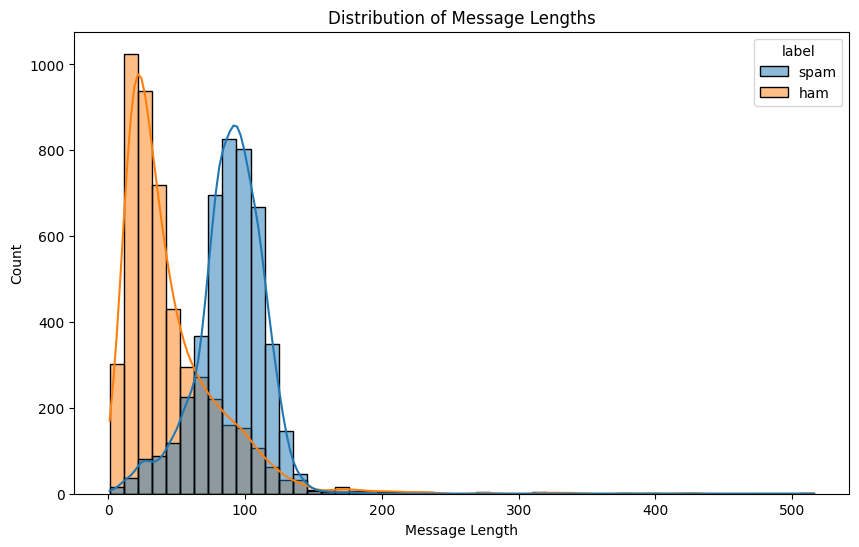

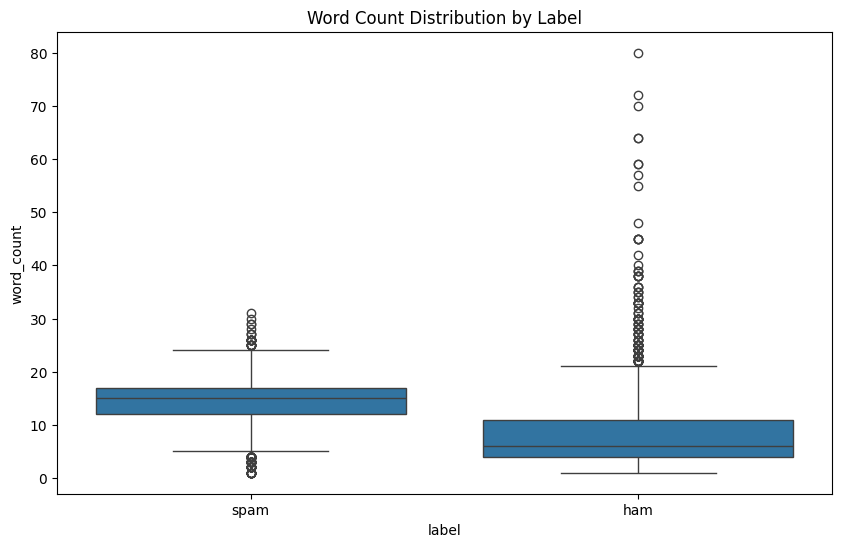

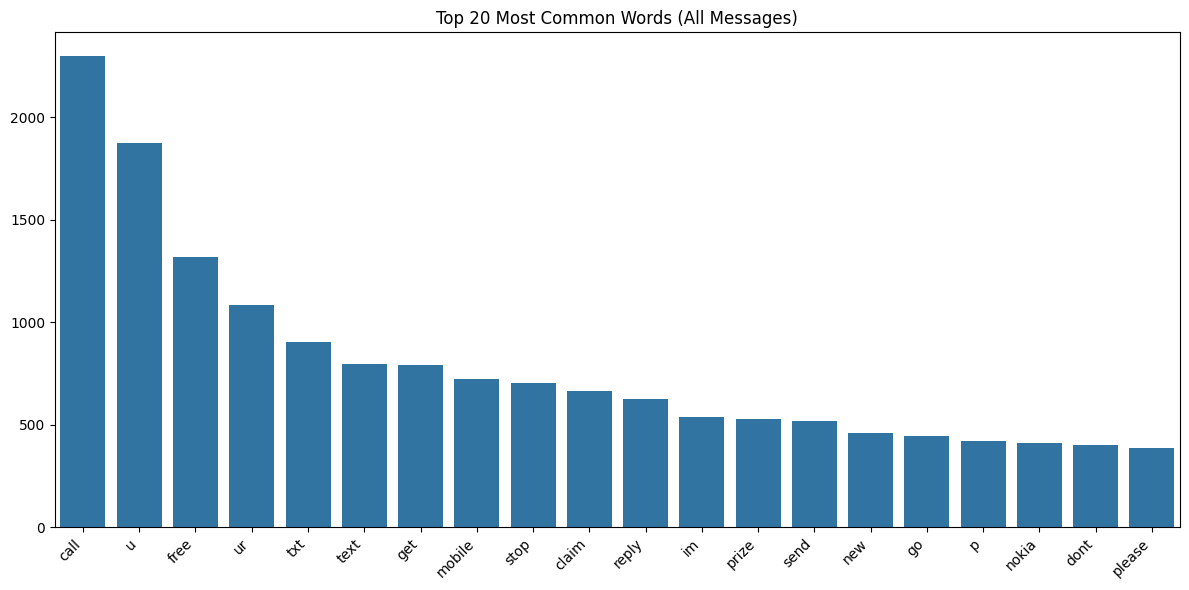

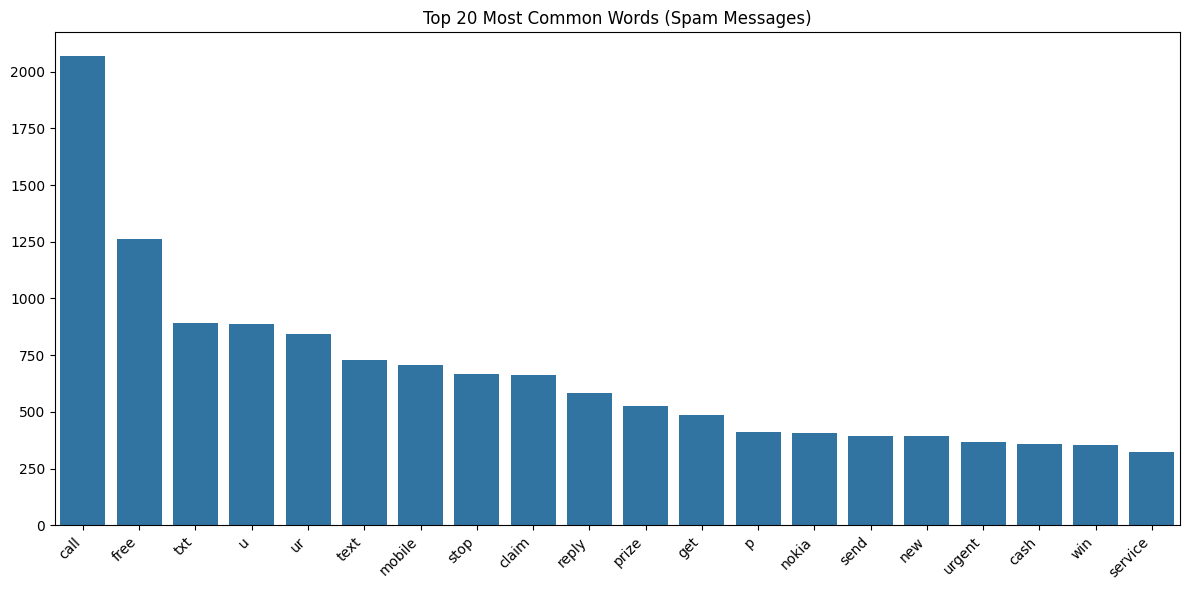

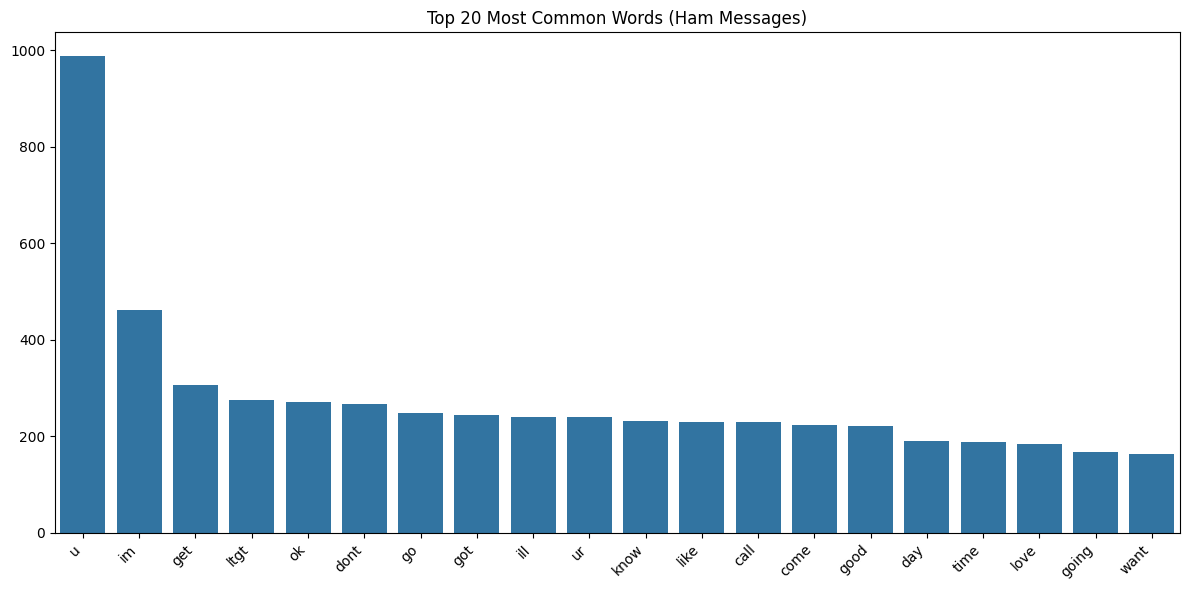

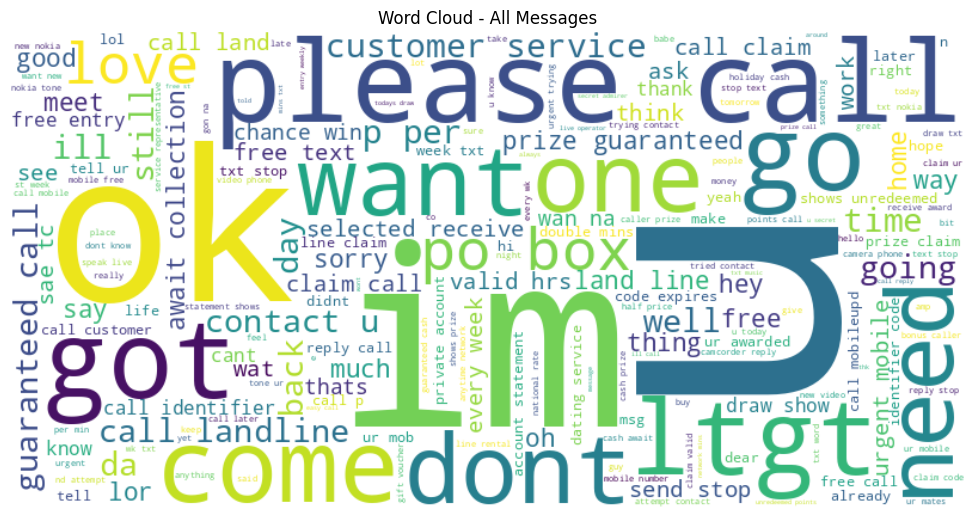

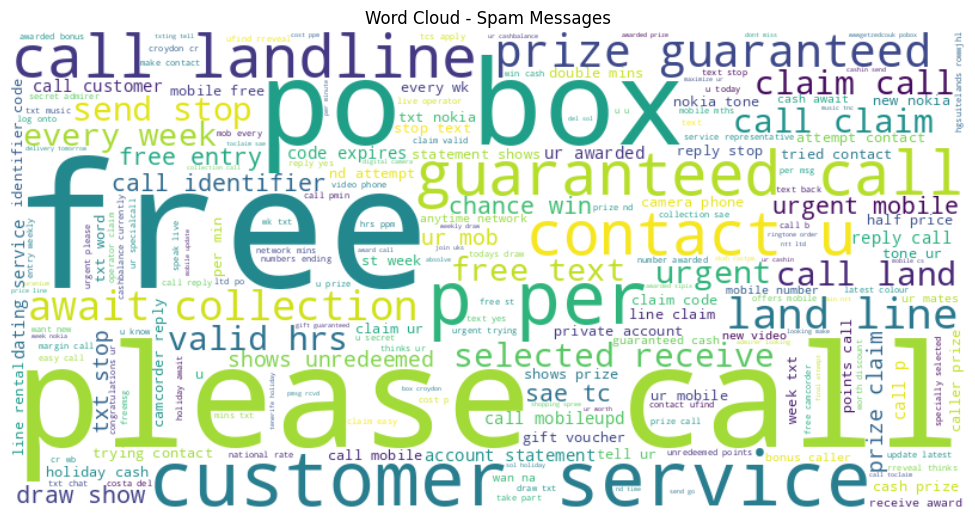

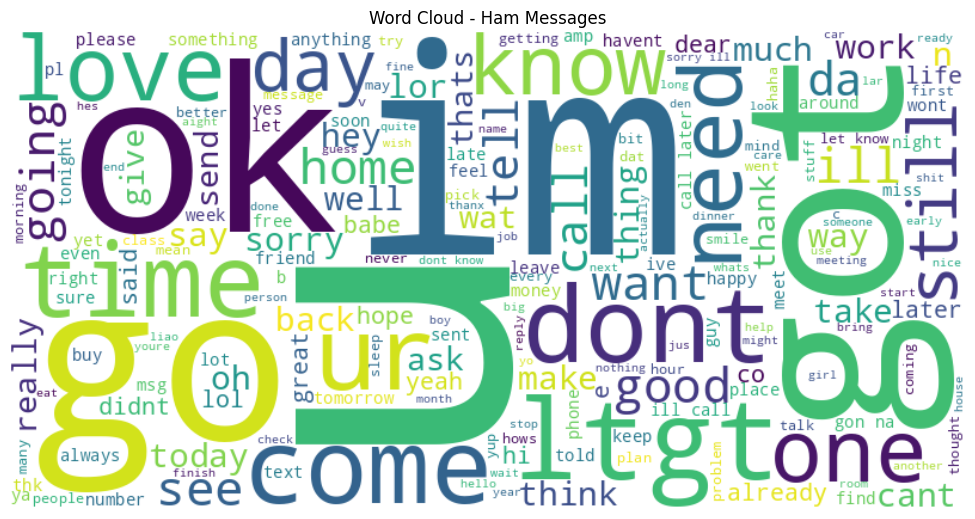

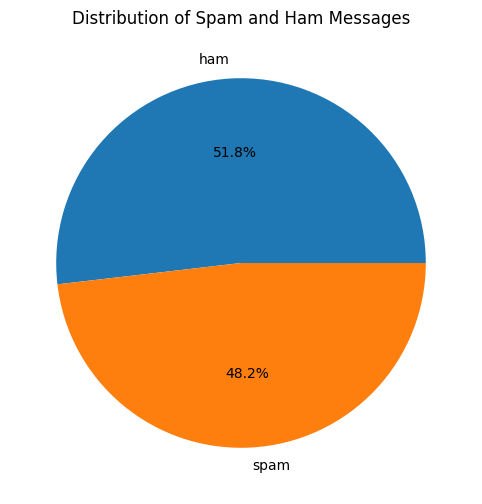

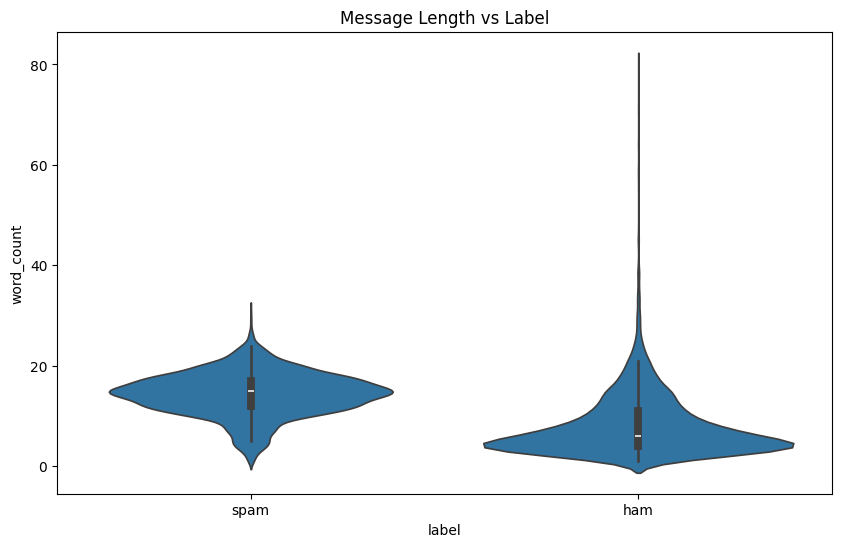

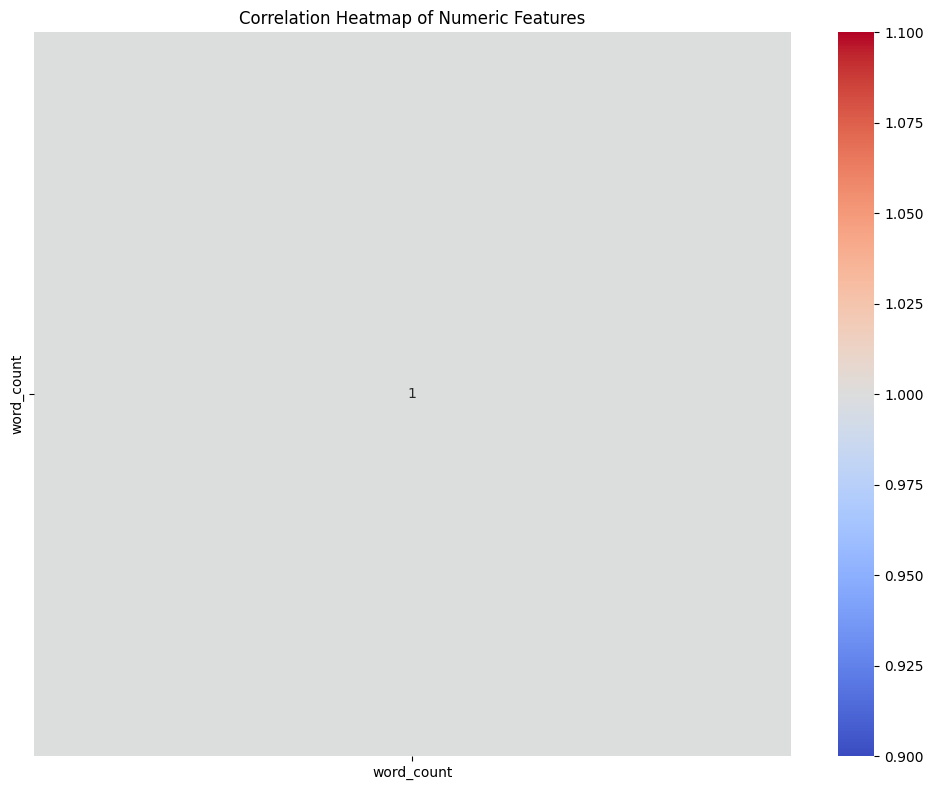

All visualizations have been displayed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Ensure you have the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
base_path = '/content/drive/MyDrive/Coventry_Final_Year_Projects/CHARAN'
df = pd.read_csv(os.path.join(base_path, 'balanced_augmented_sms_dataset.csv'))

# Convert 'message' column to string type
df['message'] = df['message'].astype(str)

# 1. Message Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=df['message'].str.len(), hue='label', kde=True, bins=50)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

# 2. Word Count Distribution
df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='word_count', data=df)
plt.title('Word Count Distribution by Label')
plt.show()

# 3. Most Common Words (excluding stopwords)
def get_top_words(text_series, n=20):
    stop_words = set(stopwords.words('english'))
    words = ' '.join(text_series).lower().split()
    words = [word for word in words if word not in stop_words]
    return Counter(words).most_common(n)

# For all messages
all_top_words = get_top_words(df['message'])
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in all_top_words], y=[word[1] for word in all_top_words])
plt.title('Top 20 Most Common Words (All Messages)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# For spam messages
spam_top_words = get_top_words(df[df['label'] == 'spam']['message'])
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in spam_top_words], y=[word[1] for word in spam_top_words])
plt.title('Top 20 Most Common Words (Spam Messages)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# For ham messages
ham_top_words = get_top_words(df[df['label'] == 'ham']['message'])
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in ham_top_words], y=[word[1] for word in ham_top_words])
plt.title('Top 20 Most Common Words (Ham Messages)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Word Clouds
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

create_wordcloud(' '.join(df['message']), 'Word Cloud - All Messages')
create_wordcloud(' '.join(df[df['label'] == 'spam']['message']), 'Word Cloud - Spam Messages')
create_wordcloud(' '.join(df[df['label'] == 'ham']['message']), 'Word Cloud - Ham Messages')

# 5. Label Distribution
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Spam and Ham Messages')
plt.ylabel('')
plt.show()

# 6. Message Length vs Label
plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='word_count', data=df)
plt.title('Message Length vs Label')
plt.show()

# 7. Time Series of Message Frequency (if timestamp is available)
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    plt.figure(figsize=(12, 6))
    df.resample('D')['label'].count().plot(label='All')
    df[df['label'] == 'spam'].resample('D')['label'].count().plot(label='Spam')
    plt.title('Daily Message Frequency')
    plt.legend()
    plt.show()

# 8. Correlation Heatmap (for numeric features)
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

print("All visualizations have been displayed.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


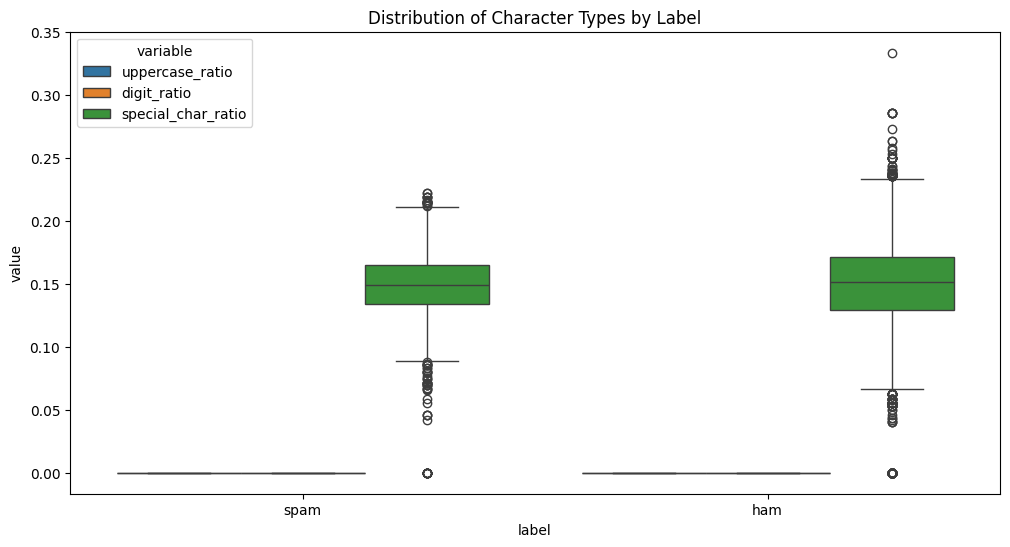

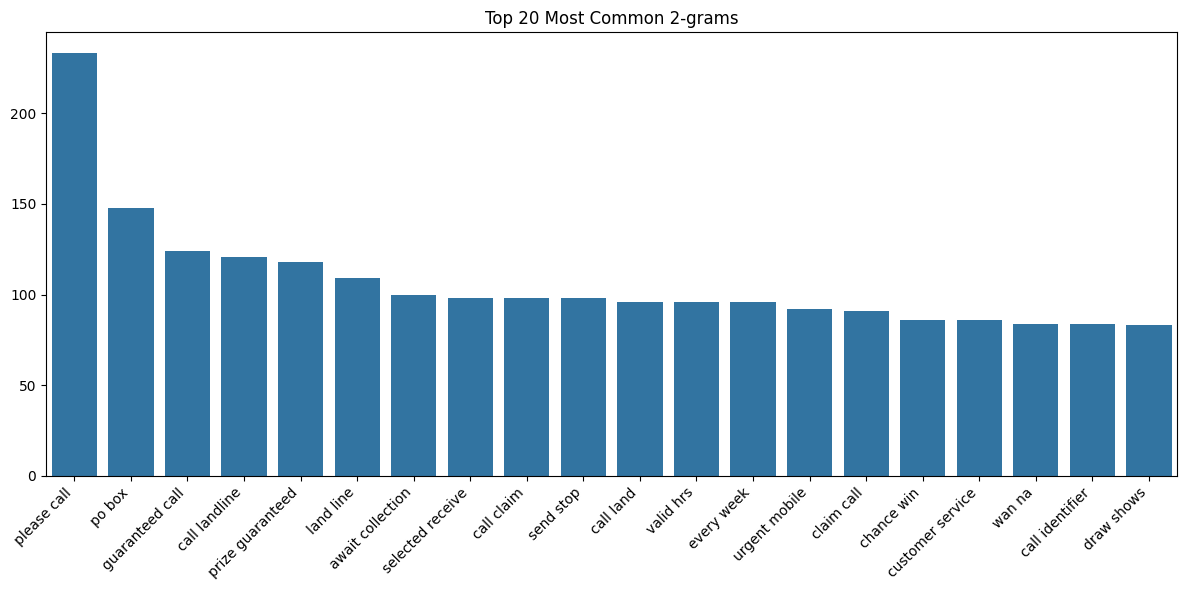

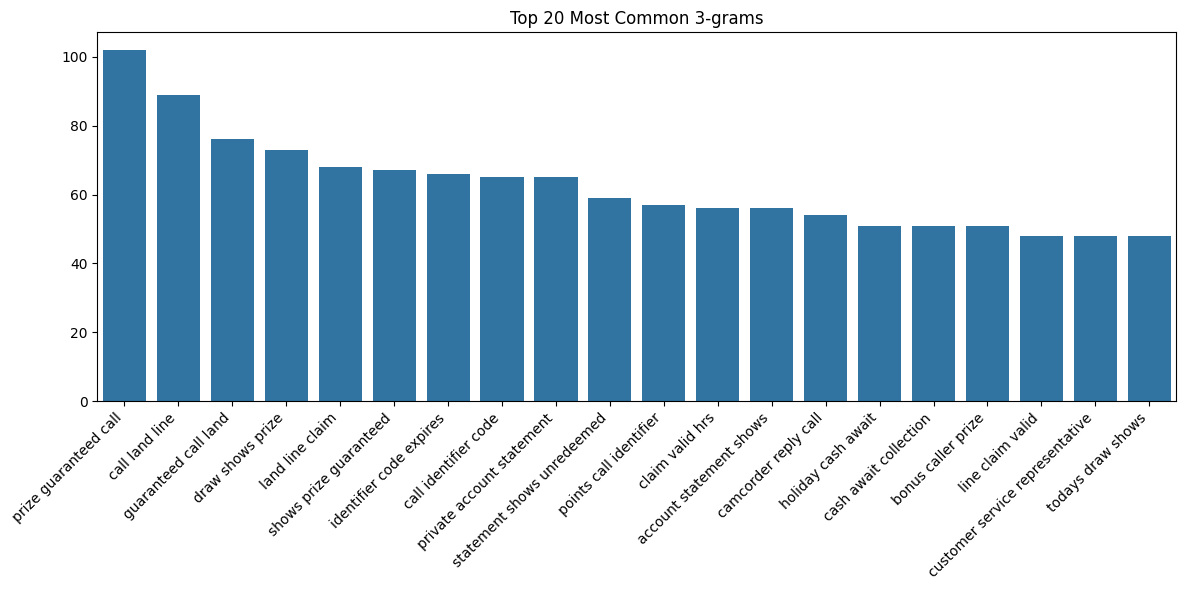

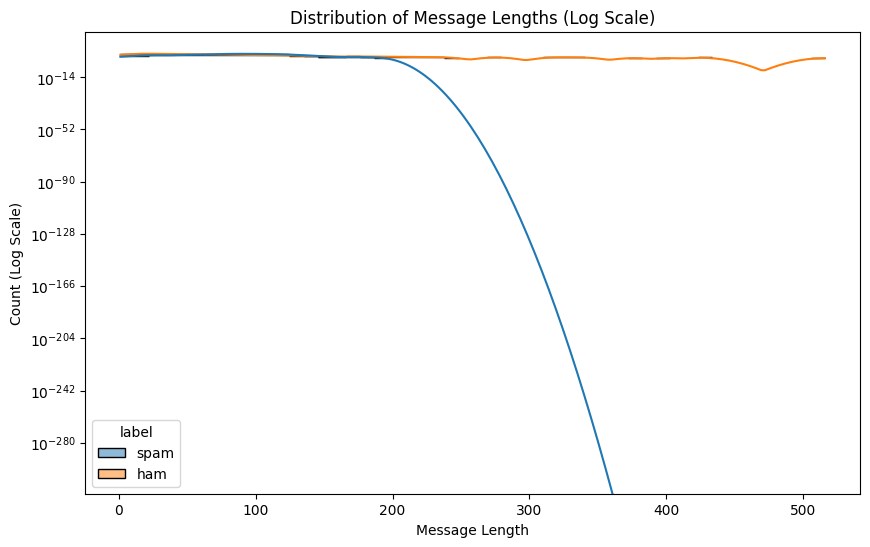

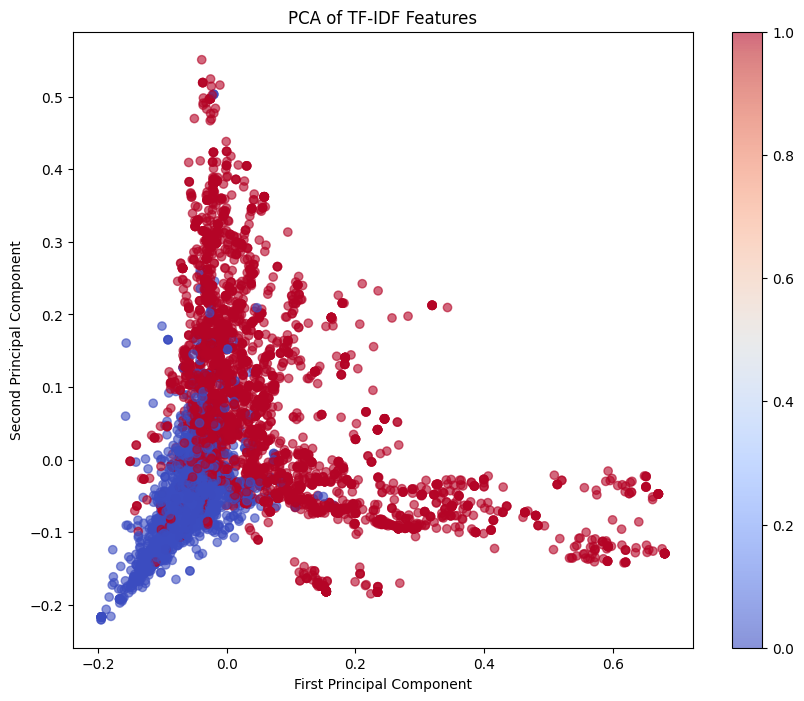

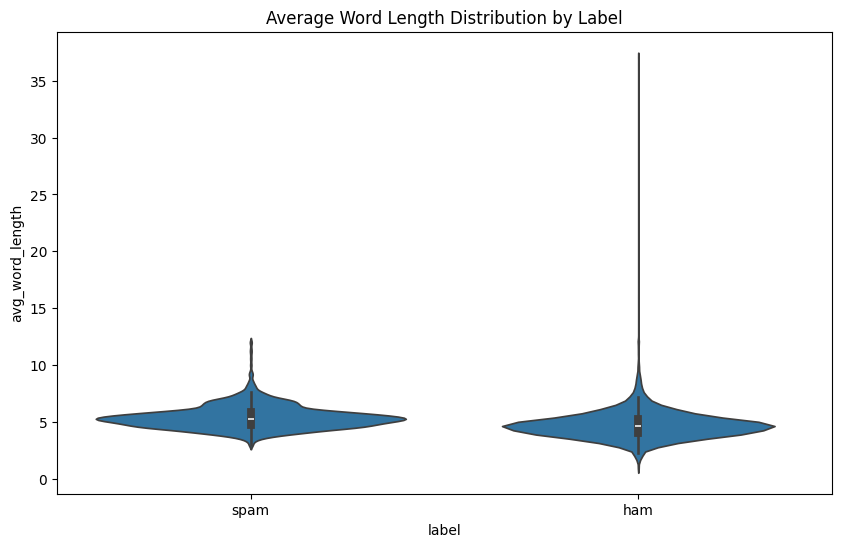

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


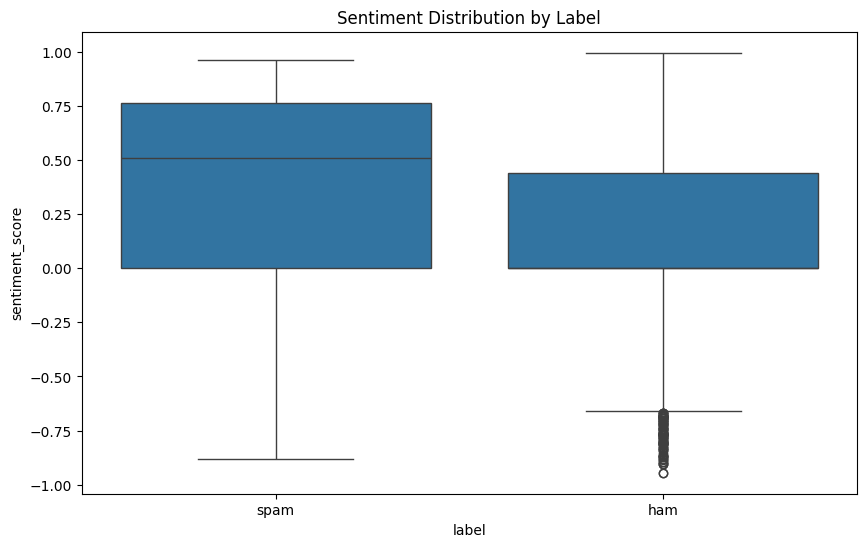

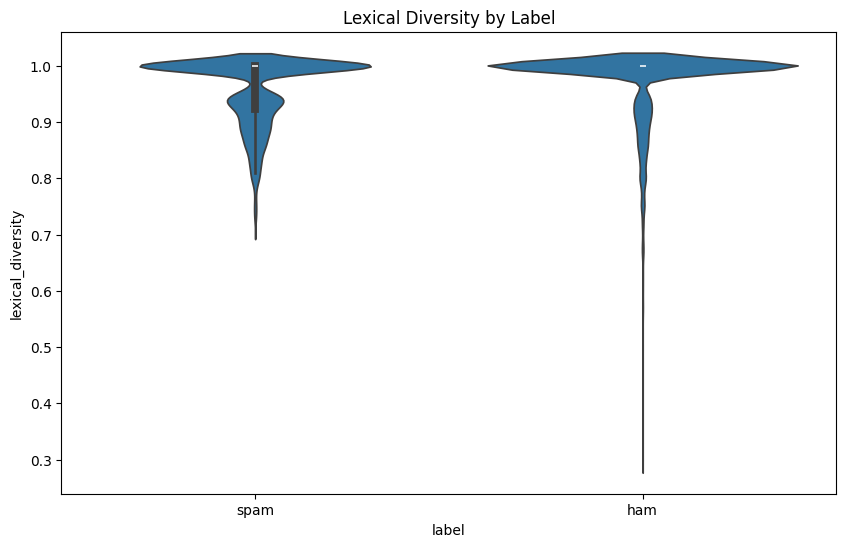

All additional visualizations have been displayed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Ensure you have the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
base_path = '/content/drive/MyDrive/Coventry_Final_Year_Projects/CHARAN'
df = pd.read_csv(os.path.join(base_path, 'balanced_augmented_sms_dataset.csv'))

# Convert 'message' column to string type
df['message'] = df['message'].astype(str)

# 9. Character Type Distribution
df['uppercase_ratio'] = df['message'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df['digit_ratio'] = df['message'].apply(lambda x: sum(1 for c in x if c.isdigit()) / len(x) if len(x) > 0 else 0)
df['special_char_ratio'] = df['message'].apply(lambda x: sum(1 for c in x if not c.isalnum()) / len(x) if len(x) > 0 else 0)

plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='value', hue='variable',
            data=pd.melt(df[['label', 'uppercase_ratio', 'digit_ratio', 'special_char_ratio']],
                         id_vars=['label'], var_name='variable', value_name='value'))
plt.title('Distribution of Character Types by Label')
plt.show()

# 10. N-gram Analysis
def plot_top_ngrams(df, n, top_k=20):
    vec = CountVectorizer(ngram_range=(n, n)).fit(df['message'])
    bag_of_words = vec.transform(df['message'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=[word[0] for word in words_freq], y=[word[1] for word in words_freq])
    plt.title(f'Top {top_k} Most Common {n}-grams')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_top_ngrams(df, 2)  # bigrams
plot_top_ngrams(df, 3)  # trigrams

# 11. Message Length Distribution (Log Scale)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=df['message'].str.len(), hue='label', kde=True, bins=50, log_scale=(False, True))
plt.title('Distribution of Message Lengths (Log Scale)')
plt.xlabel('Message Length')
plt.ylabel('Count (Log Scale)')
plt.show()

# 12. PCA Visualization of TF-IDF Features
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['message'])

pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=df['label'].map({'ham': 0, 'spam': 1}),
                      cmap='coolwarm', alpha=0.6)
plt.title('PCA of TF-IDF Features')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

# 13. Word Length Distribution
df['avg_word_length'] = df['message'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)

plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='avg_word_length', data=df)
plt.title('Average Word Length Distribution by Label')
plt.show()

# 14. Sentiment Analysis (if you have NLTK's sentiment analyzer)
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['message'].apply(lambda x: sia.polarity_scores(x)['compound'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='sentiment_score', data=df)
plt.title('Sentiment Distribution by Label')
plt.show()

# 15. Message Complexity (Lexical Diversity)
def lexical_diversity(text):
    return len(set(text.split())) / len(text.split()) if len(text.split()) > 0 else 0

df['lexical_diversity'] = df['message'].apply(lexical_diversity)

plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='lexical_diversity', data=df)
plt.title('Lexical Diversity by Label')
plt.show()

print("All additional visualizations have been displayed.")

##Checking DEMO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
import os

# Ensure necessary NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Hyperparameters
MAX_LENGTH = 128
GRU_HIDDEN_SIZE = 128
DROPOUT_RATE = 0.3

# Define the model architecture
class EnhancedBertGRUModel(nn.Module):
    def __init__(self, bert_model, gru_hidden_size, dropout_rate, num_features):
        super().__init__()
        self.bert = bert_model
        self.gru = nn.GRU(input_size=768, hidden_size=gru_hidden_size, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(embed_dim=gru_hidden_size*2, num_heads=8)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(gru_hidden_size*2 + num_features, 1)

    def forward(self, input_ids, attention_mask, features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
        gru_output, _ = self.gru(bert_output)
        attn_output, _ = self.attention(gru_output, gru_output, gru_output)
        dropped = self.dropout(attn_output[:, -1, :])
        combined = torch.cat([dropped, features], dim=1)
        output = self.fc(combined)
        return torch.sigmoid(output)

# Load the saved model and necessary components
def load_model_and_components(base_path):
    model_state = torch.load(os.path.join(base_path, 'models_V6', 'enhanced_bert_gru_model.pt'), map_location=torch.device('cpu'))
    num_features = model_state['fc.weight'].shape[1] - (GRU_HIDDEN_SIZE * 2)

    model = EnhancedBertGRUModel(BertModel.from_pretrained('bert-base-uncased'), GRU_HIDDEN_SIZE, DROPOUT_RATE, num_features)
    model.load_state_dict(model_state)
    model.eval()

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Load the TF-IDF vectorizer
    tfidf = TfidfVectorizer(max_features=num_features - 3)  # Subtract 3 for custom features

    return model, tokenizer, tfidf, num_features

# Preprocess the input message
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Function to classify a message
def classify_message(message, model, tokenizer, tfidf, num_features, device):
    # Preprocess the message
    processed_message = preprocess_text(message)

    # Fit and transform TF-IDF if it's not fitted yet
    if not hasattr(tfidf, 'vocabulary_'):
        tfidf.fit([processed_message])
    tfidf_features = tfidf.transform([processed_message]).toarray()

    # Tokenize the message
    encoding = tokenizer.encode_plus(
        processed_message,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Get custom features
    custom_features = np.array([
        [len(message),  # message length
         sum(1 for c in message if c.isupper()),  # capital letters count
         1 if 'http' in message or 'www.' in message else 0]  # has URL
    ])

    # Combine TF-IDF and custom features
    features = np.hstack((tfidf_features, custom_features))

    # Ensure the features match the expected size
    if features.shape[1] < num_features:
        padding = np.zeros((features.shape[0], num_features - features.shape[1]))
        features = np.hstack((features, padding))
    elif features.shape[1] > num_features:
        features = features[:, :num_features]

    # Prepare the input for the model
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    features_tensor = torch.tensor(features, dtype=torch.float).to(device)

    # Get the model prediction
    with torch.no_grad():
        output = model(input_ids, attention_mask, features_tensor)

    # Interpret the output
    prediction = 'spam' if output.item() > 0.5 else 'ham'
    confidence = output.item() if prediction == 'spam' else 1 - output.item()

    return prediction, confidence

# Main function to classify messages
def classify_sms(message):
    base_path = '/content/drive/MyDrive/Final_Model'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the model and components
    model, tokenizer, tfidf, num_features = load_model_and_components(base_path)
    model.to(device)

    # Classify the message
    prediction, confidence = classify_message(message, model, tokenizer, tfidf, num_features, device)

    return f"The message is classified as: {prediction.upper()} (Confidence: {confidence:.2f})"

# Example usage
if __name__ == "__main__":
    test_messages = [
        "URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18",
        "Hi, how are you doing? Want to meet up for coffee this afternoon?",
        "I'm going to be a bit late for the meeting. Start without me if needed.",
        "Servicenumbers Get agency insider information for free: https://chat.whatsapp.com/E9u5Mbm6QkdLsFF3e0n8WS areblockedforbyonwithremarkswwwmmkbusin",
        "Greesh is a lover boy"

    ]

    for msg in test_messages:
        print(f"Message: {msg}")
        print(classify_sms(msg))
        print()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Message: URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The message is classified as: SPAM (Confidence: 0.95)

Message: Hi, how are you doing? Want to meet up for coffee this afternoon?
The message is classified as: HAM (Confidence: 0.92)

Message: I'm going to be a bit late for the meeting. Start without me if needed.
The message is classified as: HAM (Confidence: 0.60)

Message: Servicenumbers Get agency insider information for free: https://chat.whatsapp.com/E9u5Mbm6QkdLsFF3e0n8WS areblockedforbyonwithremarkswwwmmkbusin
The message is classified as: SPAM (Confidence: 0.68)

Message: Greesh is a lover boy
The message is classified as: HAM (Confidence: 0.74)

